In [52]:
Vmax = 3.8e-9*25 #ugP/um2/hour
Vmax = Vmax*1e6 #ugP.mm-2.hour-1
DP = 1e-5 #cm**2-s-1, diffusion coefficient of small ions in water
DP = DP*1e2*3600 #mm**2-h-1, diffusion coefficient of small ions in water
C0 = 3.5 #ug/mL=ug/cm**-3
C0 = 3.5*1e-3 #ug/mm**-3

DP,Vmax,C0

(3.6, 0.095, 0.0035)

In [224]:
C0 = 500 #mg.L-1
C0 = 500*1e3 #ug.L-1
C0 = C0 * 1e-3 #ug.cm-3
C0 = C0 *1e-3 #ug.ùm-3
C0

0.5

In [99]:
def signed_sqrt(x,alpha = 1/2):
    """Return the signed square root of a number."""
    if x >= 0:
        return x**alpha
    else:
        return -(-x)**alpha

/tmp/ipykernel_48/3577709316.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("winter")
/tmp/ipykernel_48/3577709316.py:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = mpl.cm.get_cmap("spring")


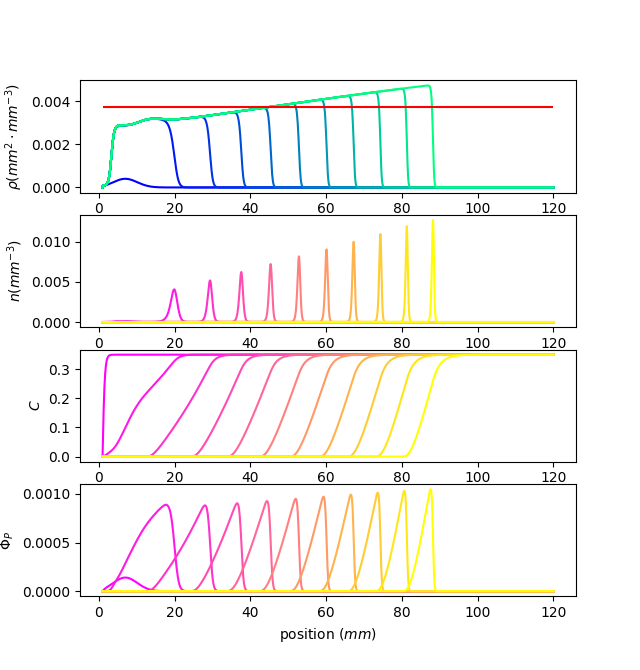

In [284]:
%matplotlib widget
from dolfin import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
plt.close("all")
set_log_active(False)
class Simulation:
    """
    A class for simulating a finite element problem using the FEniCS framework.

    Attributes:
    -----------
    Length: float
        Length of the interval domain.
    nx: int
        Number of subdivisions in the mesh.
    nT: int
        Number of time steps.
    T: float
        Total simulation time.
    C0: float
        Initial concentration value.
    Fmax: float
        Maximum flux value.
    Pprice_ideal: float
        Ideal price value.
    width: float
        Width of the plot.
    height: float
        Height of the plot.
    """
    def __init__(self, Length=120.0, nx=1200, nT=200, T=400, C0=10, Fmax=2, Pprice_ideal=20, width=3.2, height=2,speed = 0.230,adaptation_rate = 1e-4):
        self.Length = Length
        self.nx = nx
        self.dx = Length/nx
        self.nT = nT
        self.T = T
        self.dt = T/nT
        self.C0 = C0 #ug.mm-3
        self.Fmax = Fmax
        self.Pprice_ideal = Pprice_ideal
        self.width = width
        self.height = height
        self.speed = speed
        self.adaptation_rate = adaptation_rate
        self.speed_penalty = 2
        self._setup_simulation()

    def _setup_simulation(self):
        # Set up the simulation: define mesh, function spaces, initial conditions, etc.
        """
        Sets up the initial conditions and parameters for the simulation.
        """
        # Create mesh and define function space
        self.mesh = IntervalMesh(self.nx, 1, self.Length)
        P1 = FiniteElement('P', interval, 1)
        element = MixedElement([P1, P1, P1])
        self.V = FunctionSpace(self.mesh, element)

        # Define initial conditions
        u0 = Expression(('0.0001*exp(-0.1*pow(abs(x[0]-7),2))', 
                         f'(1-exp(-3*(x[0]-1)))*{self.C0}', '0.0004*exp(-0.05*pow(abs(x[0]-7),2))'), degree=1)
        rexp = Expression(('1/x[0]', '0', '0'), degree=1)
        self.r = interpolate(rexp, self.V)
        self.invr, _, _ = split(self.r)
        self.u_n = interpolate(u0, self.V)

        # Splitting functions for later use
        self.u = Function(self.V)
        self.n, self.C, self.rho = split(self.u)   #mm-3,ug.mm-3,mm2.mm-3
        self.n_n, self.C_n, self.rho_n = split(self.u_n)
        self.v_1, self.v_0, self.v_2 = TestFunctions(self.V)

        # Set parameters and constants
        self.dt = self.T / self.nT
        self.alphval = 0.39 #.h-1
        self.alphval0 = self.alphval
        self.betaval = 0.022 #mm.h-1 length coefficient
        self.betaval = 0.022*1e4 #mm.h-1 SA coefficient
        
        self.beta = Constant(self.betaval) #mm**4.h-1
        self.D = 0.002 #mm**2.h-1
        self.D0 = self.D #mm**2.h-1
        
        self.D2 = Constant(0.36) #mm**2.h-1
        self.n_mid = 0.5*(self.n_n + self.n)
        self.v_sval = self.speed #mm.h-1
        self.s_scal = self.speed #mm.h-1
        self.v_s = Constant((self.v_sval,)) #mm.h-1
        self.Vmax = self.Fmax #ug.mm**-2.h-1
        self.Kp = 0.001 #ug.mm-3
        # Boundary conditions
        u_L = (Constant(0.0), Constant(0.0), Constant(0.0))
        u_R = (Constant(0.0), Constant(self.C0), Constant(0.0))
        bc_L = DirichletBC(self.V, u_L, 'near(x[0], 1.0)')
        bc_R = DirichletBC(self.V, u_R, f'near(x[0], {self.Length})')
        self.bcs = [bc_L, bc_R]

    def _make_F(self, alphval,D):
        # Define the variational problem F
        alpha = Constant(alphval)
        D = Constant(D)
        # dn/dt
        F = self.n*self.v_1*dx - self.n_n*self.v_1*dx 
        # D lapplacian(n)
        F += D*dot(grad(self.n), grad(self.v_1))*self.dt*dx
        # To account for cylindrical coordinates
        F += self.invr*D*dot(grad(self.n), Constant((1,)))*self.v_1*self.dt*dx
        
        #v.grad(n)
        F += self.dt*dot(grad(self.n_mid),self.v_s)*self.v_1*dx
        # To account for cylindrical coordinates
        F += self.invr*self.dt*self.n_mid*Constant(self.v_sval)*self.v_1*dx
        
        #alpha*n - beta * n * rho
        F += self.beta*self.v_1*self.rho*(self.n)*self.dt*dx
        F -= alpha*(self.n)*self.v_1*self.dt*dx
        
        #d rho/dt = vn
        F -= self.dt*self.s_scal*self.n*self.v_2*dx-(self.rho-self.rho_n)*self.v_2*dx


        # dC/dt
        F += self.C*self.v_0*dx - self.C_n*self.v_0*dx 
        # Vmax * rho * C/(C+Kp)
        F += self.Vmax*(self.rho)*(self.C/(self.Kp+self.C))*self.v_0*self.dt*dx
        # Diffusion 
        F += self.D2*dot(grad(self.C), grad(self.v_0))*self.dt*dx
        # To account for cylindrical coordinates
        F += self.invr*self.D2*dot(grad(self.C), Constant((1,)))*self.v_0*self.dt*dx

        return F
    def integrate(self, plot=False):
        """
        Integrate the problem over time and optionally plot the results.
        Returns arrays of C(x, t), rho(x, t), and n(x, t) over the simulation.

        Parameters:
        -----------
        plot: bool
            If True, plot the results using matplotlib.

        Returns:
        --------
        C_xt: list of arrays
            Concentration C as a function of position x and time t.
        rho_xt: list of arrays
            Density rho as a function of position x and time t.
        n_xt: list of arrays
            Quantity n as a function of position x and time t.
        """
        # Initialize arrays to store C(x, t), rho(x, t), and n(x, t)
        C_xt = []
        rho_xt = []
        n_xt = []
        P_prices = []
        alphavals = []
        # Initialize matplotlib plots if needed
        if plot:
            fig, axs = plt.subplots(4, 1, figsize=(self.width*2, self.height * 3.35))
            cmap = mpl.cm.get_cmap("winter")
            cmap2 = mpl.cm.get_cmap("spring")

        # Time-stepping loop
        V2 = FunctionSpace(self.mesh, 'P', 1)
        X = np.linspace(1, self.Length, self.nx)
        i=0
        for t in np.linspace(0, self.T, self.nT):
            F = self._make_F(self.alphval,self.D)
            solve(F == 0, self.u, self.bcs)
            self.u_n.assign(self.u)
            _n, _C, _rho = self.u.split()

            # Interpolate and store the results
            n_field = interpolate(_n, V2)
            rho_field = interpolate(_rho, V2)
            C_field = interpolate(_C, V2)
            Ccost = np.sum([n_field(x)*np.pi*x*self.dx*self.v_sval for x in X])
            Ccost *= (self.v_sval/0.15)**(self.speed_penalty)
            Pacquisition = np.sum([self.Vmax*(C_field(x)/(C_field(x)+self.Kp))*rho_field(x)*np.pi*x*self.dx for x in X]) #ug.h-1.mm-1
            Pprice = Ccost/Pacquisition
            alphavals.append(self.alphval)
            self.alphval = self.alphval + self.dt*self.adaptation_rate*signed_sqrt((self.Pprice_ideal-Pprice)/self.Pprice_ideal,alpha = 1/2)
            self.D = self.D0*self.alphval0/self.alphval
            # print(2*(np.sqrt(self.D*self.alphval)))
            n_xt.append([n_field(x) for x in X])
            rho_xt.append([rho_field(x) for x in X])
            C_xt.append([C_field(x) for x in X])
            P_prices.append(Pprice)
            # Plotting logic
            if plot and i % (self.nT//10) == 0:
                axs[1].plot(X, n_xt[-1], color=cmap2(t / self.T))
                axs[0].plot(X, rho_xt[-1], color=cmap(t / self.T))
                axs[2].plot(X, C_xt[-1], color=cmap2(t / self.T))
                axs[3].plot(X, [C_xt[-1][i] * rho_xt[-1][i] for i in range(len(X))], color=cmap2(t / self.T))
            i+=1
            

        # Finalize plot settings if plotting
        if plot:
            axs[1].plot(X, n_xt[-1], color=cmap2(t / self.T))
            axs[0].plot(X, rho_xt[-1], color=cmap(t / self.T))
            satrho = np.median([rho for rho in rho_xt[-1] if rho>0.0001])
            
            axs[0].hlines(satrho,np.min(X),np.max(X), color="red")
            
            axs[2].plot(X, C_xt[-1], color=cmap2(t / self.T))
            axs[3].plot(X, [C_xt[-1][i] * rho_xt[-1][i] for i in range(len(X))], color=cmap2(t / self.T))
            axs[0].set_ylabel(r'$\rho (mm^2 \cdot mm^{-3})$')
            axs[1].set_ylabel('$n (mm^{-3})$')
            axs[2].set_ylabel('$C$')
            axs[3].set_ylabel('$\Phi_P$')
            
            axs[3].set_xlabel('position ($mm$)')
            plt.show()

        return C_xt, rho_xt, n_xt,P_prices,alphavals
        

# Example usage:
C0=0.35
Pprice_ideal = 0.008

sim = Simulation(speed = 0.10,C0=C0,T = 360,nT=3600,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = 1e-3)
C_xt, rho_xt, n_xt,P_prices,alphavals = sim.integrate(plot=True)


In [289]:
sim.dt

0.1

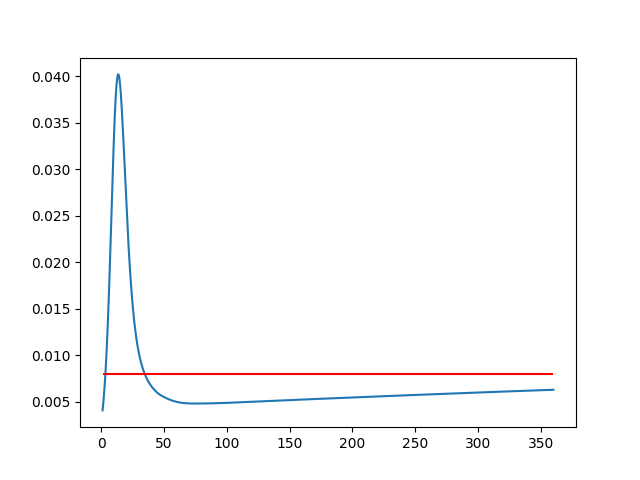

In [285]:
fig,ax = plt.subplots()
ts = np.linspace(1, sim.T, sim.nT)
ax.plot(ts,P_prices)
ax.hlines(Pprice_ideal,np.min(ts),np.max(ts),color="red")
# ax.set_yscale("log")

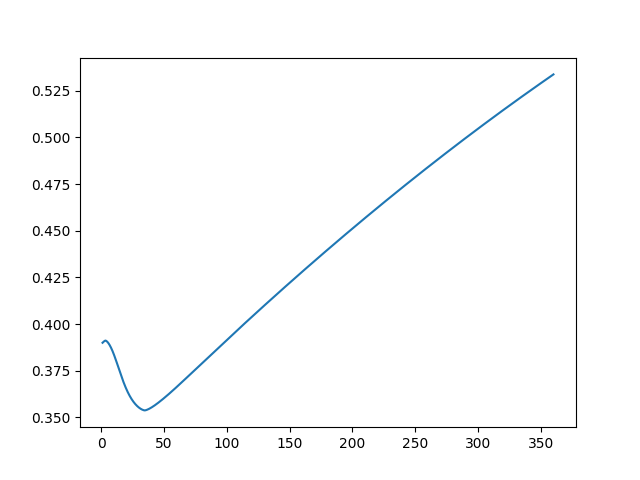

In [286]:
fig,ax = plt.subplots()
ts = np.linspace(1, sim.T, sim.nT)
ax.plot(ts,alphavals)
# ax.set_yscale("log")

In [287]:
0.10+2*np.sqrt(sim.D*sim.alphval)

0.15585696017507578

0.19490837250233453


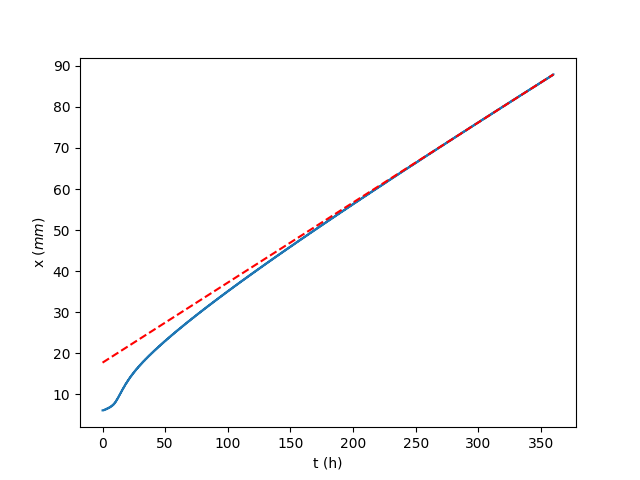

In [288]:
poss = np.argmax(n_xt,axis=1)
x = np.linspace(0,sim.T,sim.nT)
y = np.array(poss)*sim.Length/sim.nx
fit_coeffs = np.polyfit(x[3*sim.nT//4:], y[3*sim.nT//4:], 1)
fit_line = np.polyval(fit_coeffs, x)

# Plot data and linear fit
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, fit_line, 'r--')
ax.set_xlabel('t (h)')
ax.set_ylabel('x ($mm$)')
print(fit_coeffs[0])

In [217]:
def get_rhosat(speed,C0=10,Pprice_ideal = 1/15):
    sim = Simulation(speed = speed,C0=C0,T = 360,nT=3600,Pprice_ideal = Pprice_ideal,Fmax = 0.1,adaptation_rate = 1e-3)
    C_xt, rho_xt, n_xt,P_prices,_ = sim.integrate(plot=False)
    rho_sat = np.median([rho for rho in rho_xt[-1] if rho>0.1])
    poss = np.argmax(n_xt,axis=1)
    x = np.linspace(0,sim.T,sim.nT)
    y = np.array(poss)*sim.Length/sim.nx
    fit_coeffs = np.polyfit(x[3*sim.nT//4:], y[3*sim.nT//4:], 1)
    return(rho_sat,fit_coeffs[0])

In [218]:
def get_dynamics(speed,C0=10,Pprice_ideal = 1/15):
    sim = Simulation(speed = speed,C0=C0,T = 360,nT=3600,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = 1e-3)
    C_xt, rho_xt, n_xt,P_prices,_ = sim.integrate(plot=True)
    return(np.array(C_xt),np.array(rho_xt),np.array(n_xt))


In [139]:
speeds

array([0.1 , 0.15, 0.2 ])

/tmp/ipykernel_48/4020946236.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("winter")
/tmp/ipykernel_48/4020946236.py:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = mpl.cm.get_cmap("spring")


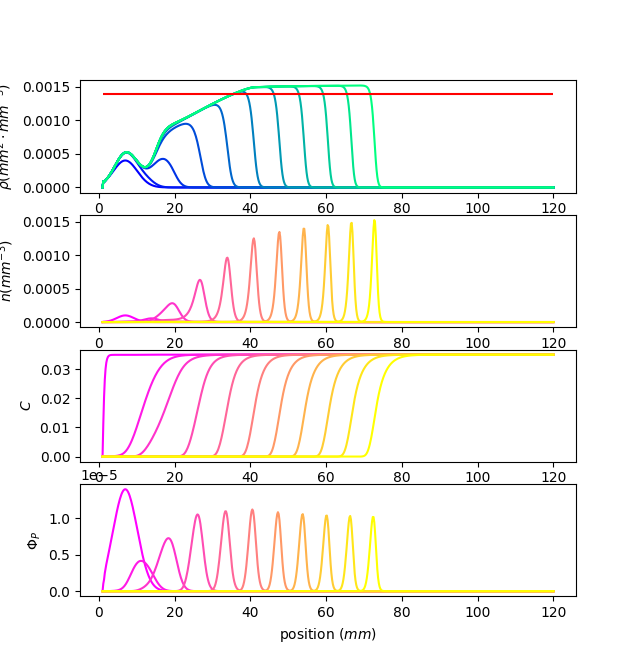

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


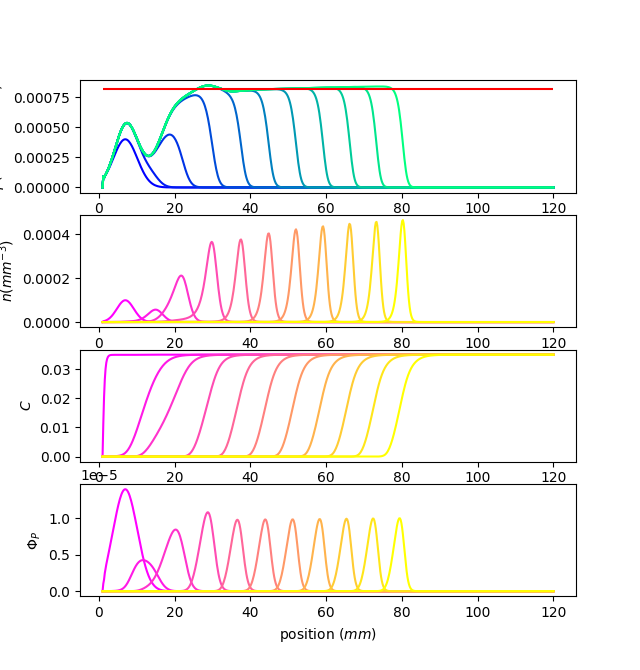

Calling FFC just-in-time (JIT) compiler, this may take some time.


/tmp/ipykernel_48/4020946236.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("winter")
/tmp/ipykernel_48/4020946236.py:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = mpl.cm.get_cmap("spring")


Calling FFC just-in-time (JIT) compiler, this may take some time.


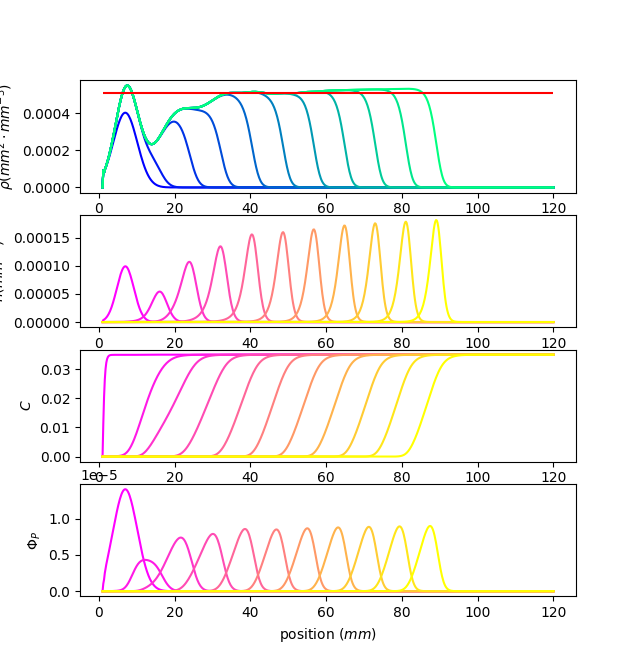

/tmp/ipykernel_48/4020946236.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("winter")
/tmp/ipykernel_48/4020946236.py:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = mpl.cm.get_cmap("spring")


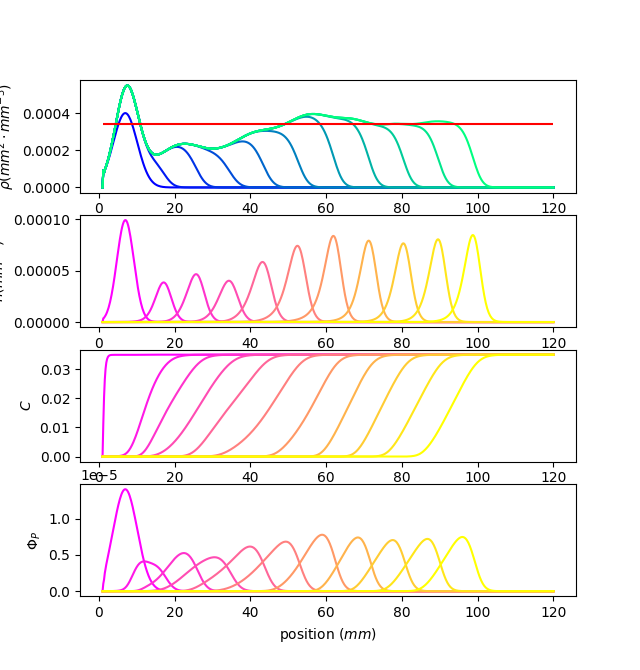

In [219]:
plt.close("all")

speeds = np.linspace(0.10,0.20,4)
C0=0.035
Pprice_ideal = 0.02
dynamics = {speed : get_dynamics(speed,C0=C0,Pprice_ideal = Pprice_ideal) for speed in speeds}


In [220]:
X = np.array([[x**2 for x in np.linspace(0,120,600)]]*3600)
dx = 80/600
Vmax = 2
Pacqu = {}
for speed in speeds:
    C_xt, rho_xt, n_xt = dynamics[speed] 
    Pacquisitions = np.sum(Vmax*C_xt*rho_xt*np.pi*X*dx,axis = 1)
    Pacqu[speed] = Pacquisitions

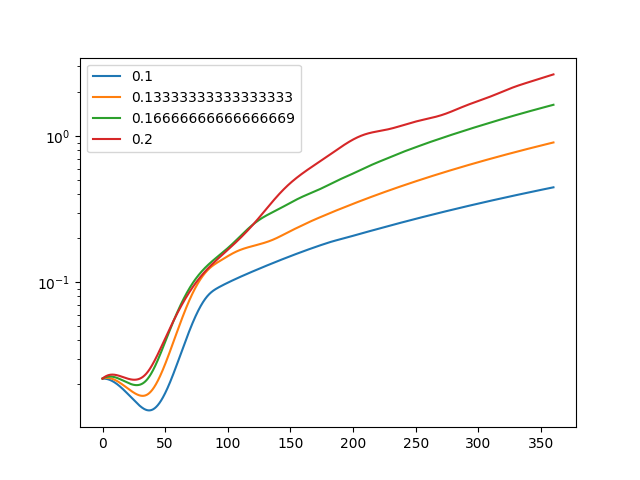

In [222]:
T = 360
fig,ax = plt.subplots()
ts = np.linspace(0,T,3600)
for speed in speeds:
    ax.plot(ts,Pacqu[speed],label=speed)
ax.set_yscale("log")
# ax.set_xscale("log")
ax.legend()

In [127]:
speeds = np.linspace(0.10,0.20,3)
C0=10
Pprice_ideal = 1/(3*C0)
rho_sats_speeds = [get_rhosat(speed,C0=C0,Pprice_ideal = Pprice_ideal) for speed in speeds]
    

In [128]:
speeds_observed = [speed for _,speed in rho_sats_speeds]
rho_sats = [rho for rho,_ in rho_sats_speeds]

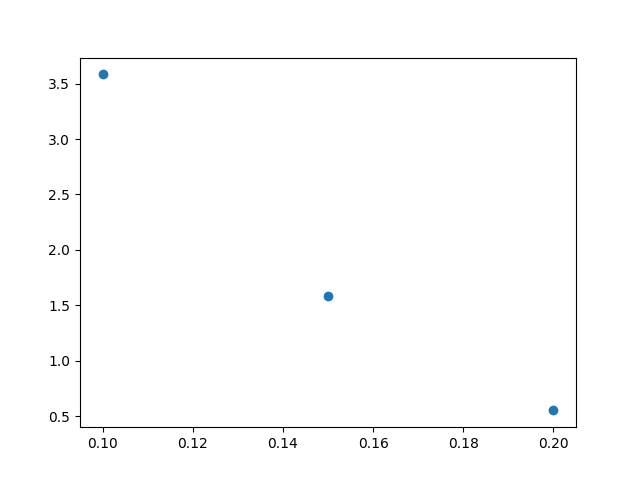

In [129]:
fig,ax = plt.subplots()
ax.scatter(speeds,rho_sats)
fit_coeffs = np.polyfit(speeds, rho_sats, 1)
# ax.set_xscale("log")
# ax.set_yscale("log")

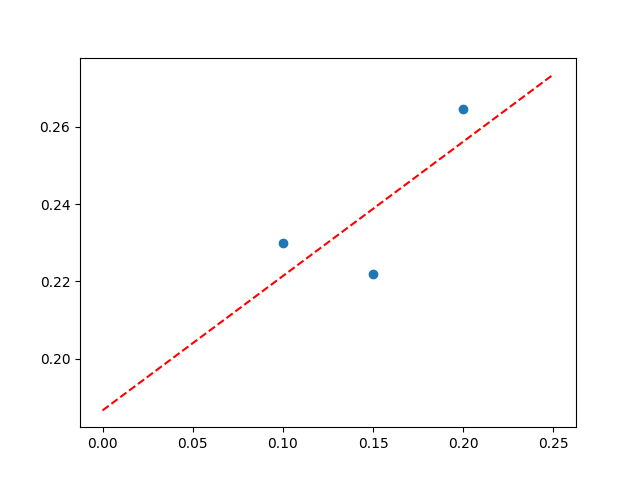

In [130]:
fig,ax = plt.subplots()
ax.scatter(speeds,speeds_observed)
fit_coeffs = np.polyfit(speeds, speeds_observed, 1)
x = [0,0.25]
fit_line = np.polyval(fit_coeffs, x)

# Plot data and linear fit
ax.plot(x, fit_line, 'r--')
# ax.set_xscale("log")
# ax.set_yscale("log")